In [63]:
import numpy as np
import pandas as pd
import pydub
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import datetime
import os
import sklearn
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

https://github.com/tyiannak/pyAudioAnalysis

## initial attempt

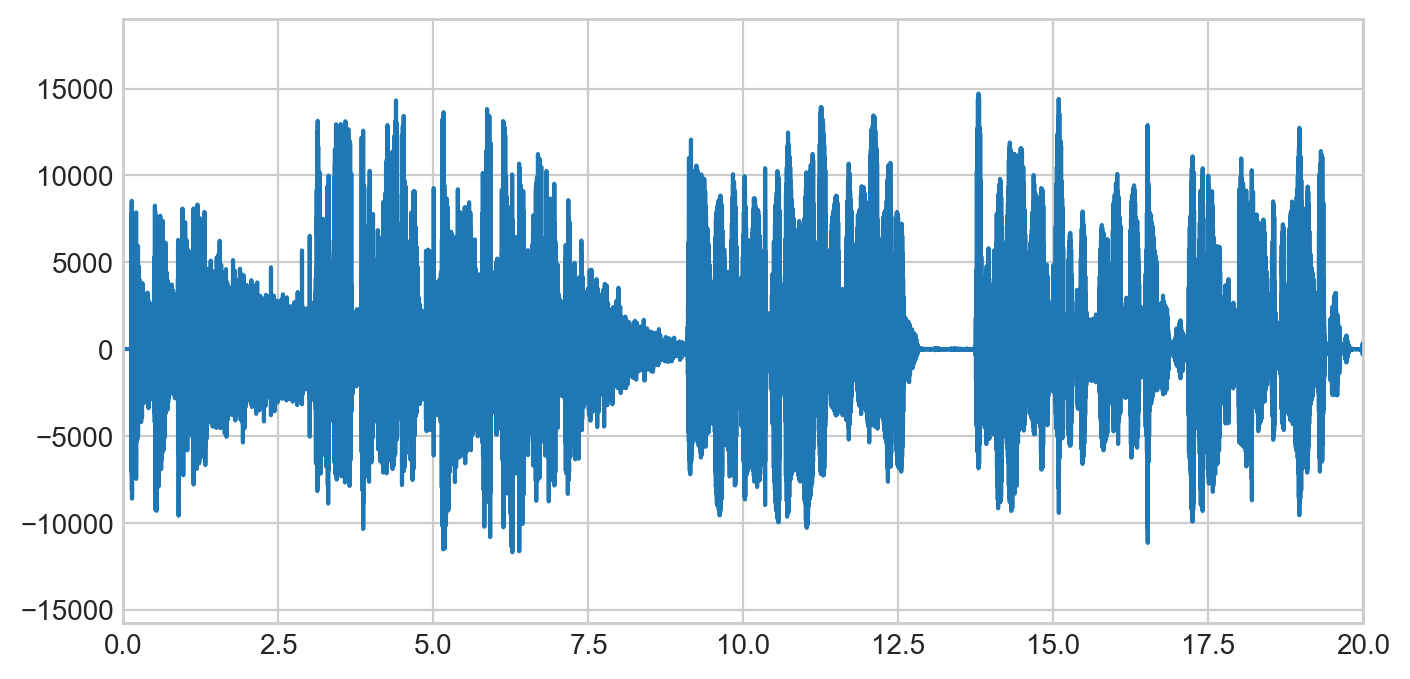

In [72]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y
    
# load audio
filename = './data/Leere_Supermarkt.mp3'
# data, fs = sf.read(filename, dtype='float32')
fs, data = read(filename)
time = np.linspace(0, len(data) / fs, num=len(data))

# creat channel name
prefix = 'channel_'
n_channels = data.shape[1]
n_str = np.arange(1, n_channels + 1, 1, dtype=str)
channels = [prefix + i for i in n_str]

# convert to pandas df
pd_data = pd.DataFrame(data, columns=channels)
pd_data['seconds'] = time

# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])

ax.set_xlim([0, 20])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

## inaSpeechSegmenter

### Audio Segmentation
https://github.com/ina-foss/inaSpeechSegmenter

### Speech to Text
https://cloud.ibm.com/apidocs/speech-to-text/speech-to-text?code=python

### Proofreading
https://www.bitblokes.de/languagetool-3-4-ist-veroeffentlicht-korrekturlesen-mit-open-source/

In [73]:
# Load the API (Current warning is related to h5py and has no consequences)
from inaSpeechSegmenter import Segmenter, seg2csv
seg = Segmenter()

In [74]:
segments = seg(filename)
pd_segments = pd.DataFrame(segments).rename(columns={0:'Class', 1:'Start', 2:'Stop'})

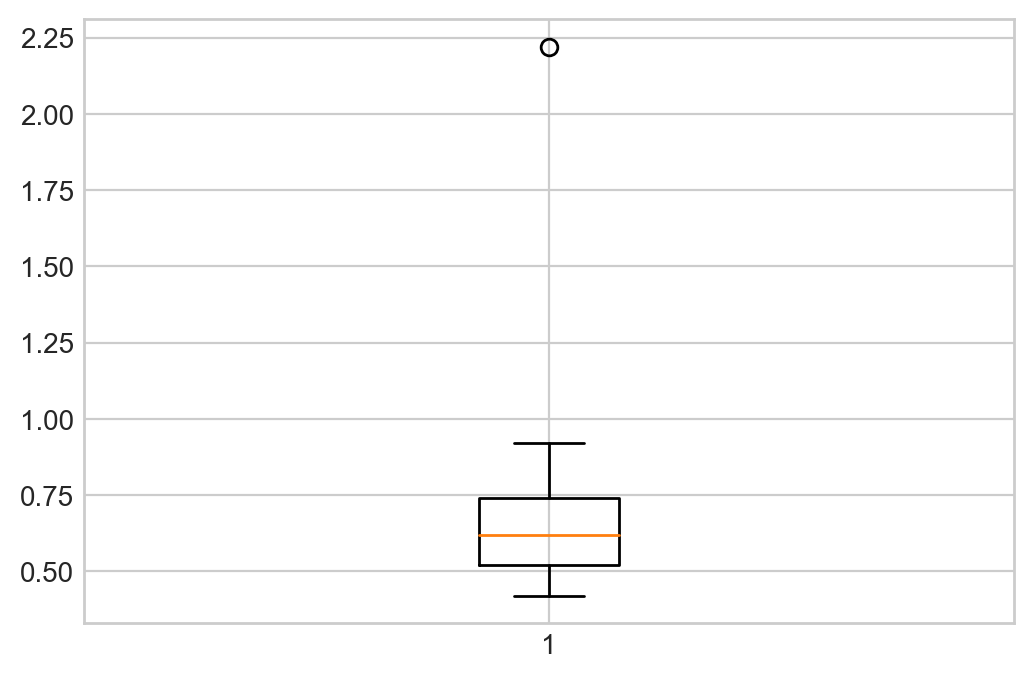

In [75]:
pd_segments['interval'] = pd_segments['Stop'] - pd_segments['Start']
plt.boxplot(pd_segments[pd_segments.Class=='noEnergy']['interval'])
plt.show()

In [87]:
pd_segments

,Class,Start,Stop,interval
0,music,0.00,2.88,2.88
1,male,2.88,6.90,4.02
2,music,6.90,8.42,1.52
3,noEnergy,8.42,9.08,0.66
4,male,9.08,12.82,3.74
5,noEnergy,12.82,13.74,0.92
6,male,13.74,27.18,13.44
7,noEnergy,27.18,27.90,0.72
8,male,27.90,44.56,16.66
9,noEnergy,44.56,45.18,0.62


In [82]:
Q2 = np.quantile(pd_segments[pd_segments.Class=='noEnergy']['interval'].values, 0)
Q2

0.4200000000000017

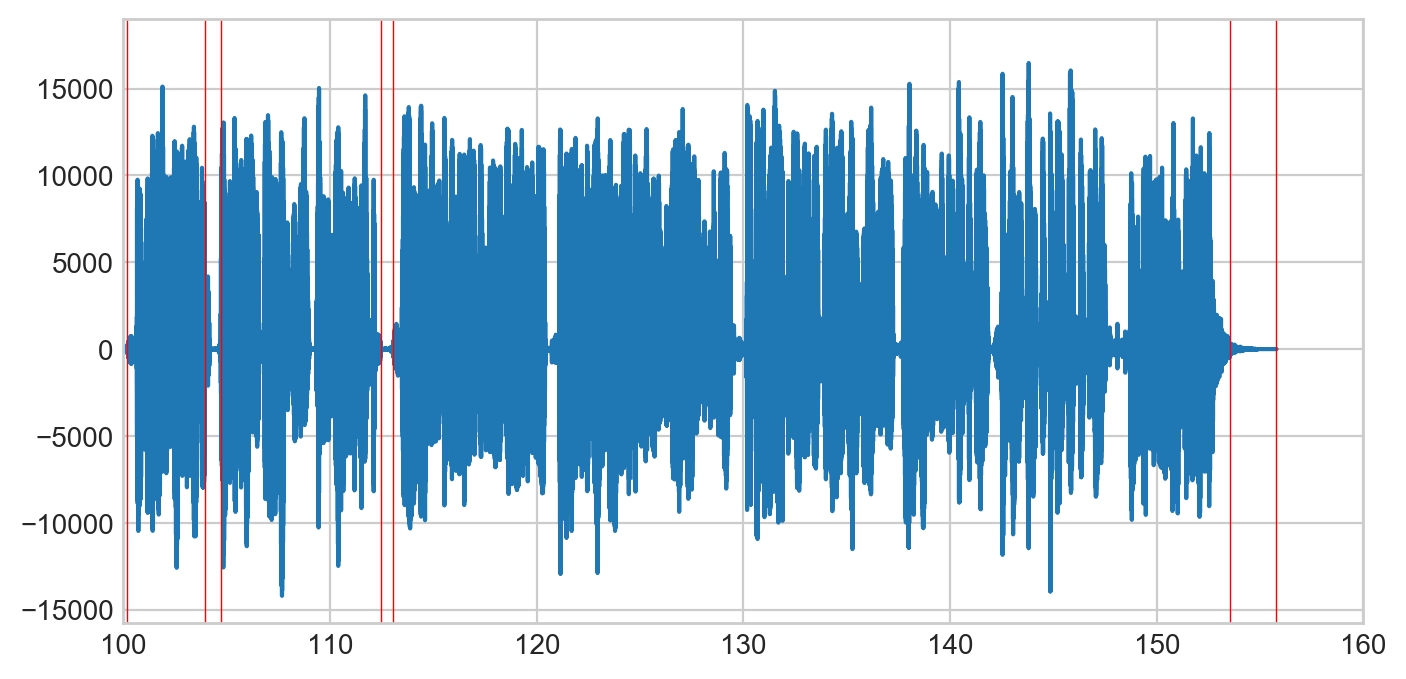

In [86]:
# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])
pd_pause = pd_segments[pd_segments.Class == 'noEnergy']
for i in range(len(pd_pause)):
    ax.axvline(x=pd_pause.iloc[i]['Start'], color='red', lw=0.5)
    ax.axvline(x=pd_pause.iloc[i]['Stop'], color='red', lw=0.5)

ax.set_xlim([100, 160])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

In [93]:
index = []

for i in range(len(pd_segments)):
    if pd_segments.iloc[i].Class == 'noEnergy':
        pause = pd_segments.iloc[i].interval
        if pause >= Q2:
            index.append(i)

seg = [(str(datetime.timedelta(seconds=0)), 
        str(datetime.timedelta(seconds=pd_segments.iloc[index[0]].Start)).split('.')[0])]

for i in range(1, len(index)):
    left = str(datetime.timedelta(seconds=pd_segments.iloc[index[i-1]].Start)).split('.')[0]
    right = str(datetime.timedelta(seconds=pd_segments.iloc[index[i]].Start)).split('.')[0]
    sentence = (left, right)
    seg.append(sentence)

seg

[('0:00:00', '0:00:08'),
 ('0:00:08', '0:00:12'),
 ('0:00:12', '0:00:27'),
 ('0:00:27', '0:00:44'),
 ('0:00:44', '0:00:57'),
 ('0:00:57', '0:01:09'),
 ('0:01:09', '0:01:15'),
 ('0:01:15', '0:01:26'),
 ('0:01:26', '0:01:30'),
 ('0:01:30', '0:01:39'),
 ('0:01:39', '0:01:43'),
 ('0:01:43', '0:01:52'),
 ('0:01:52', '0:02:33')]

In [43]:
pd_segments[~(pd_segments.Class =='noEnergy')].iloc[0]
# apt-get install ffmpeg libavcodec-extra

Class       female
Start         0.52
Stop          0.88
interval      0.36
Name: 1, dtype: object